In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt, lfilter
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt
import scipy.signal as signal
from scipy.integrate import simps
import scipy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split


In [3]:
# ---------- FUNCTIONS ---------- #

#___SCALING___#
def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

#___LOWPASS FILTER___#
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered

#___DOWNSAMPLING___#
def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


In [4]:
# LOAD FILES

def get_file_paths_and_labels(data_folder, task_numbers):
  file_paths = []
  labels = []
  for task_number in task_numbers:
      for file in os.listdir(data_folder):
          if file.endswith(task_number + 'h5'):
              file_path = os.path.join(data_folder, file)
              file_paths.append(file_path)
              labels.append(assign_label(file))
  return file_paths, labels

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Cross/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def load_data(file_path):
  with h5py.File(file_path, 'r') as f:
      dataset_name = get_dataset_name(file_path)
      matrix = f.get(dataset_name)[:]
      return matrix

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name

def assign_label(file_name):
  if file_name.startswith("rest"):
      return 0
  elif file_name.startswith("task_motor"):
      return 1
  elif file_name.startswith("task_story"):
      return 2
  elif file_name.startswith("task_working"):
      return 3
  else:
      return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files

In [5]:
############################################################################
# ------------------------------ Train Data ------------------------------ #
############################################################################

In [6]:
# Call Preprocessing functions
def preprocess_data(data, i):
  print(f"*** FILE {i} ***")
  data = apply_scaling(data)
  print("scaling applied: shape:", data.shape, end=', ')
  data = apply_lowpass(data)
  print("lowpass applied: shape:", data.shape, end=', ')
  data = apply_downsampling(data)
  print("downsam applied: shape:", data.shape)
  return np.array(data)

In [7]:
# Retieve the initial data from the folder

fmri_data_folder = find_fmri_data_folder('/content/drive')
print("fmri_data_folder:", fmri_data_folder)

meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

fmri_data_folder: /content/drive/MyDrive/Courses/Pattern Recognition/Lab/Group Assignment/meg_data/Cross/train


In [8]:
print("## Initial shapes of the data ##")
print("MEG:", meg_train_data_array.shape)
print("Labels:",labels_train_array.shape)

## Initial shapes of the data ##
MEG: (64, 248, 35624)
Labels: (64,)


In [9]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 8906))
print(processed_data.shape)
for i in range(meg_train_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_train_data_array[i], i+1)

clear_output(wait=True)
print("*** ALL DONE ***")
print("Processed data shape:", processed_data.shape)

*** ALL DONE ***
Processed data shape: (64, 248, 8906)


In [10]:
X_train = processed_data
labels = to_categorical(labels_train_array, num_classes=4)

del processed_data, labels_train_array, meg_train_data_array

In [11]:
print("## Final shapes of the data ##")
print("MEG:", X_train.shape)
print("Labels:",labels.shape)

## Final shapes of the data ##
MEG: (64, 248, 8906)
Labels: (64, 4)


In [12]:
# ----- MODEL ----- #

def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))  # or appropriate activation function

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [13]:
data = np.expand_dims(X_train, axis=3)
del X_train

In [14]:
data.shape

(64, 248, 8906, 1)

In [14]:
from keras.utils import Sequence

class MEGDataGenerator(Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data          # Your data
        self.labels = labels      # Corresponding labels
        self.batch_size = batch_size
        self.indices = np.arange(data.shape[0])

    def __len__(self):
        # Compute the number of batches (each of size batch_size)
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        # Fetch a batch of data
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.data[inds]

        # Process your data here (e.g., reshaping, normalization)
        # Assuming you need to add a channel dimension and normalize
        batch_x = batch_x.reshape((-1, 248, 8906, 1))  # Add channel dimension
        batch_x = batch_x / np.max(batch_x)           # Simple normalization

        batch_y = self.labels[inds]
        return batch_x, batch_y

In [16]:
from sklearn.model_selection import KFold

model = build_cnn_model(input_shape=(248,8906,1), num_classes=4)

kf = KFold(n_splits=4)

fold = 1
for train_index, test_index in kf.split(data):
    print(f"Training on fold {fold}...")
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Build and compile your model here
    # model = ...

    # Train the model
    model.fit(X_train, y_train, epochs=6, batch_size=4)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    print(f"Scores for fold {fold}: {scores}")

    fold += 1

Training on fold 1...
Epoch 1/6
12/12 [==============================] - 19s 1s/step - loss: 4.8439 - accuracy: 0.2083
Epoch 2/6
12/12 [==============================] - 17s 1s/step - loss: 0.6729 - accuracy: 0.5417
Epoch 3/6
12/12 [==============================] - 17s 1s/step - loss: 0.4803 - accuracy: 0.6042
Epoch 4/6
12/12 [==============================] - 16s 1s/step - loss: 0.1880 - accuracy: 1.0000
Epoch 5/6
12/12 [==============================] - 16s 1s/step - loss: 0.0286 - accuracy: 1.0000
Epoch 6/6
1/1 [==============================] - 2s 2s/step - loss: 0.8453 - accuracy: 0.5000
Scores for fold 1: [0.8452722430229187, 0.5]
Training on fold 2...
Epoch 1/6
12/12 [==============================] - 16s 1s/step - loss: 0.2342 - accuracy: 0.7708
Epoch 2/6
12/12 [==============================] - 16s 1s/step - loss: 0.0781 - accuracy: 1.0000
Epoch 3/6
12/12 [==============================] - 16s 1s/step - loss: 0.0058 - accuracy: 1.0000
Epoch 4/6
12/12 [========================

In [16]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_expanded, y_train, test_size=0.2)

# Define your model (as previously discussed)
model = build_cnn_model(input_shape=(248,8906,1), num_classes=4)

batch_size = 4  # Set your batch size
generator = MEGDataGenerator(X_train_expanded, y_train, batch_size)


# Fit the model
history = model.fit(generator,
                    epochs=4,              # Number of epochs
                    verbose=1)          # Adjust based on your data and hardware capability

# Optionally, save your model
model.save('my_meg_model.h5')

Epoch 1/4
16/16 [==============================] - 38s 1s/step - loss: 0.9106 - accuracy: 0.2969
Epoch 2/4
16/16 [==============================] - 25s 2s/step - loss: 0.5632 - accuracy: 0.3125
Epoch 3/4
16/16 [==============================] - 22s 1s/step - loss: 0.5041 - accuracy: 0.5156
Epoch 4/4
16/16 [==============================] - 23s 1s/step - loss: 0.4120 - accuracy: 0.7188


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


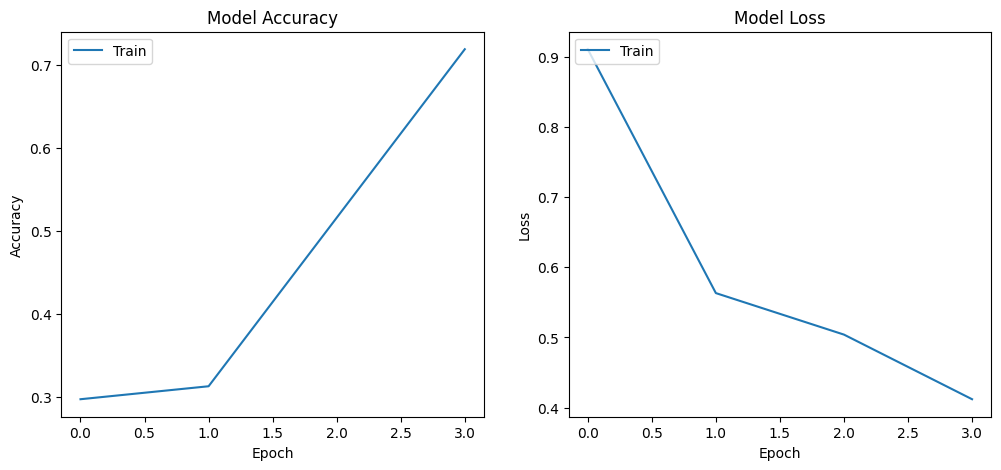

In [17]:
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()

In [18]:
############################################################################
# ------------------------------ Test Data ------------------------------ #
############################################################################

In [17]:
# ----- RETRIEVE TEST DATA ----- #

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Cross/test1')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

print("## Initial shapes of the test data ##")
print(meg_test_data_array.shape)
print(labels_test_array.shape)

## Initial shapes of the test data ##
(16, 248, 35624)
(16,)


In [18]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data = np.zeros((meg_test_data_array.shape[0], meg_test_data_array.shape[1], 8906))
print(processed_data.shape)
for i in range(meg_test_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_test_data_array[i], i+1)

clear_output(wait=True)
print("*** ALL DONE ***")
print("Processed data shape:", processed_data.shape)

*** ALL DONE ***
Processed data shape: (16, 248, 8906)


In [19]:
X_test = processed_data
y_test = to_categorical(labels_test_array, num_classes=4)

del processed_data, labels_test_array

In [20]:
print("## Data after processing ##")
print("MEG:", X_test.shape)
print("Labels:", y_test.shape)

## Data after processing ##
MEG: (16, 248, 8906)
Labels: (16, 4)


In [21]:
X_test_expanded = np.expand_dims(X_test, axis=3)
del X_test

In [22]:
print("## Data after processing ##")
print("MEG:", X_test_expanded.shape)
print("Labels:", y_test.shape)

## Data after processing ##
MEG: (16, 248, 8906, 1)
Labels: (16, 4)


In [23]:
# TEST CNN

test_scores = model.evaluate(X_test_expanded, y_test, verbose=1)
print("CNN Test Loss:", test_scores)


1/1 [==============================] - 1s 1s/step - loss: 1.3746 - accuracy: 0.3750
CNN Test Loss: [1.3745801448822021, 0.375]


In [25]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_expanded)

# Convert predictions and true labels to single labels if they are one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

1/1 [==============================] - 3s 3s/step


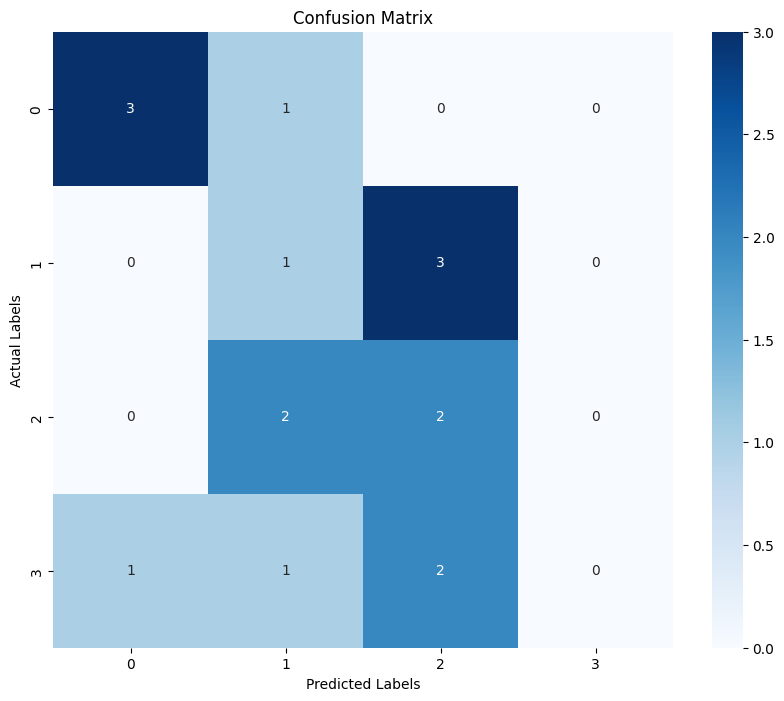

In [26]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
